In [1]:
import warnings

warnings.filterwarnings('ignore')

### 研究报告

关于更新的说明：

上周提交的报告的基本思路是首先构造一个股票池，然后基于alphalens对股票池进行分组测试，计算因子的绩效，从而选择出一个更好的因子指标，

但是本周实际测试是：发现这样实际上已经涉及到选股了，再加上后续的信号假设，做起来比较玛法，最后针对单只标的的通用性测试也没有办法做。

所以这次换了一种思路，只测试单只标的的因子的IC值，IC值越大代表因子在这个标的中越有效，然后也尝试了简化进出场的信号假设，最终的研究报告如下：

### 选择8H的BTCUSDT:binance数据，起始日期为20180101

##### 当然在测试环节中，我也尝试了其他频率，如1H，4H,6H,12H的数据，发现其实效果都还可以，但是综合考虑了胜率和交易频次，最后选择了8H

In [2]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '8H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

12.793333053588867


In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv8H = HFDataView()

In [4]:
dv8H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [5]:
def RankPct(df):
    return df.rank(axis=1, pct=True)

### 选择alpha101中的alpha4和alpha7作为研究的因子


根据公式，我们可以看出：

Alpha004是一个基于滚动9日最低价的反转策略

alpha007也是一个基于交易量和收盘价的反转策略


In [6]:
alpha4 = dv8H.add_formula('alpha4_C','Ts_Rank(low,9)',add_data=True,register_funcs={'RankPct':RankPct})
alpha7=dv8H.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)

In [7]:
alpha4 = dv8H.get_ts('alpha4_C',date_type='datetime')
alpha7 = dv8H.get_ts('alpha7_C',date_type='datetime')

In [ ]:
close = dv8H.get_ts('close', date_type='datetime')

### 这里需要计算不同周期的收益率，从而确定因子在不同周期的IC值，最后确定策略的持仓周期

In [9]:
one_Period_df = close.pct_change(1).shift(1)
five_Period_df = close.pct_change(5).shift(1)
ten_Period_df = close.pct_change(10).shift(1)
twen_Period_df = close.pct_change(20).shift(1)

In [10]:
one_corr = alpha4['BTCUSDT:binance'].corr(one_Period_df['BTCUSDT:binance'])
five_corr = alpha4['BTCUSDT:binance'].corr(five_Period_df['BTCUSDT:binance'])
ten_corr = alpha4['BTCUSDT:binance'].corr(ten_Period_df['BTCUSDT:binance'])
twen_corr = alpha4['BTCUSDT:binance'].corr(twen_Period_df['BTCUSDT:binance'])
print('1日收益相关系数:%.2f'%one_corr)
print('5日收益相关系数:%.2f'%five_corr)
print('10日收益相关系数:%.2f'%ten_corr)
print('20日收益相关系数:%.2f'%twen_corr)

1日收益相关系数:0.46
5日收益相关系数:0.65
10日收益相关系数:0.54
20日收益相关系数:0.39


####  根据计算，我们可以看出来当持仓周期设置为5时，因子值与下期收益率的相关系数，即IC值最大，因此选择5作为持仓周期

In [11]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

#### 这里是根据上面得到的最佳持仓周期，画出收益率与因子值的变化曲线，有一个直观的感受

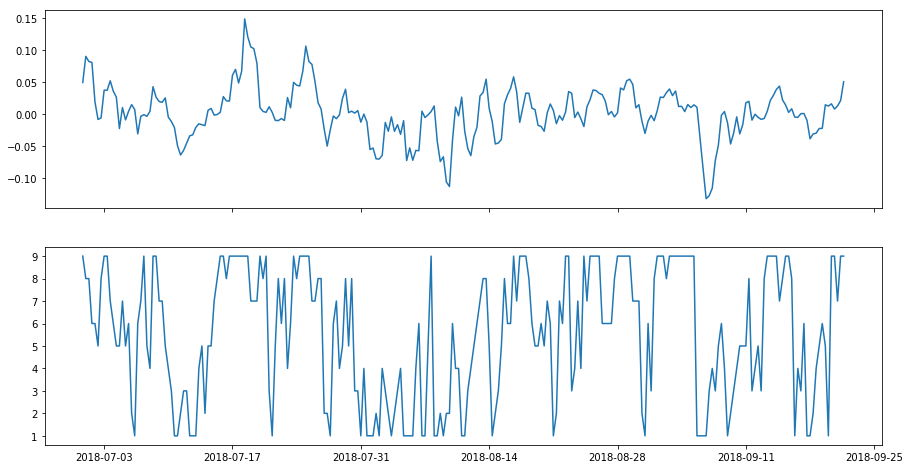

In [12]:
plot_chart(five_Period_df, alpha4 )

#### 同理，可以得到alpha7的最佳持仓周期也为5

In [13]:
one_corr = alpha7['BTCUSDT:binance'].corr(one_Period_df['BTCUSDT:binance'])
five_corr = alpha7['BTCUSDT:binance'].corr(five_Period_df['BTCUSDT:binance'])
ten_corr = alpha7['BTCUSDT:binance'].corr(ten_Period_df['BTCUSDT:binance'])
twen_corr = alpha7['BTCUSDT:binance'].corr(twen_Period_df['BTCUSDT:binance'])
print('1日收益相关系数:%.2f'%one_corr)
print('5日收益相关系数:%.2f'%five_corr)
print('10日收益相关系数:%.2f'%ten_corr)
print('20日收益相关系数:%.2f'%twen_corr)

1日收益相关系数:0.33
5日收益相关系数:0.56
10日收益相关系数:0.50
20日收益相关系数:0.39


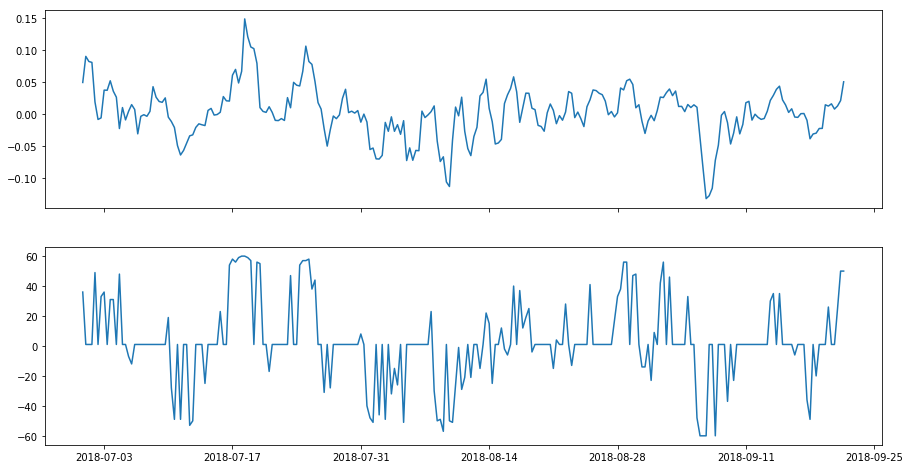

In [14]:
plot_chart(five_Period_df, alpha7 )

### 这里是为了alpha4的进场信号的判断条件，目前只能凭肉眼观察，然后主观赋值，有待后续改进

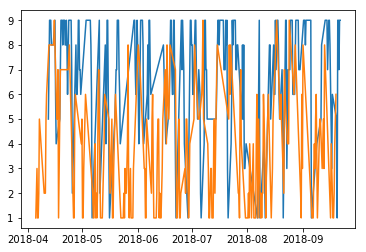

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


L1 = five_Period_df[five_Period_df['BTCUSDT:binance']>0].index.tolist()
L2 = five_Period_df[five_Period_df['BTCUSDT:binance']<0].index.tolist()
alpha4P1 = alpha4['BTCUSDT:binance'][L1]
alpha4P2 = alpha4['BTCUSDT:binance'][L2]
# five_Period_df['BTCUSDT:binance']<0
# five_Period_df[five_Period_df<0] = -1
plt.plot(alpha4P1.iloc[-250:])
plt.plot(alpha4P2.iloc[-250:])


#### 这里的进出场假设比较简单，主要是看因子值的大小，当alpha4的因子值大于6是long
#### 当alpha4的因子值小于2时，short

In [16]:
# 进场信号
long = dv8H.add_formula("longAlpha4","If(alpha4_C>6 ,2,0)", add_data=True)
short = dv8H.add_formula("shortAlpha4","If(alpha4_C<2,-2,0)", add_data=True)

# 出场信号5
close_long = dv8H.add_formula("closeLongAlpha4","If(shortAlpha4==-2,1,0)", add_data=True)
close_short = dv8H.add_formula("closeShortAlpha4","If(longAlpha4==2,-1,0)", add_data=True)

In [17]:
dv8H.get_ts('longAlpha4').stack()[dv8H.get_ts('longAlpha4').stack()==2].tail()

trade_date      symbol         
20180920080000  BTCUSDT:binance    2.0
20180920160000  BTCUSDT:binance    2.0
20180921000000  BTCUSDT:binance    2.0
20180921080000  BTCUSDT:binance    2.0
20180921160000  BTCUSDT:binance    2.0
dtype: float64

In [18]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger


def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

H:\WIN7\Anaconda2\envs\python36\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "H:\WIN7\Anaconda2\envs\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "H:\WIN7\Anaconda2\envs\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "H:\WIN7\Anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "H:\WIN7\Anaconda2\envs\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "H:\WIN7\Anaconda2\envs\python36\lib\site-packages\ipykernel\kernelapp.py", line 486

### 测试时主要修改最大持有天数，修改为5天

In [19]:
tdAlpha4 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha004')

TimingSignal(tdAlpha4, dv8H,'longAlpha4','shortAlpha4','closeLongAlpha4','closeShortAlpha4', 5, 0.05, 0.3)#

Nan Data Count (should be zero) : 0;  Percentage of effective data: 38%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 17%


In [20]:
tdAlpha4.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               11.190  -16.513   -0.764
p-value               0.000    0.000    0.446
mean                  0.038   -0.037   -0.002
std                   0.040    0.029    0.051
info_ratio            0.949   -1.301   -0.044
skewness              1.524   -0.695    0.680
kurtosis              1.656   -0.104    1.132
pct5                  0.002   -0.087   -0.080
pct25                 0.009   -0.055   -0.035
pct50                 0.021   -0.033   -0.004
pct75                 0.051   -0.011    0.018
pct95                 0.139   -0.003    0.092
occurance           140.000  162.000  302.000
win_ratio               NaN      NaN    0.464
win_mean/loss_mean      NaN      NaN    1.027


In [21]:
tdAlpha4.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.586  -9.442   -0.462
p-value              0.000   0.000    0.645
mean                 0.039  -0.037   -0.002
std                  0.036   0.033    0.051
info_ratio           1.090  -1.105   -0.040
skewness             1.761  -1.950    0.115
kurtosis             3.734   7.106    2.216
pct5                 0.002  -0.086   -0.075
pct25                0.014  -0.055   -0.038
pct50                0.031  -0.032   -0.002
pct75                0.049  -0.011    0.027
pct95                0.116  -0.002    0.077
occurance           63.000  74.000  137.000
win_ratio              NaN     NaN    0.460
win_mean/loss_mean     NaN     NaN    1.055


In [22]:
tdAlpha4.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               14.043  -18.848   -0.892
p-value               0.000    0.000    0.373
mean                  0.038   -0.037   -0.002
std                   0.039    0.030    0.051
info_ratio            0.988   -1.230   -0.043
skewness              1.584   -1.235    0.502
kurtosis              2.161    3.361    1.473
pct5                  0.002   -0.086   -0.080
pct25                 0.010   -0.055   -0.036
pct50                 0.027   -0.033   -0.004
pct75                 0.051   -0.011    0.023
pct95                 0.126   -0.003    0.089
occurance           203.000  236.000  439.000
win_ratio               NaN      NaN    0.462
win_mean/loss_mean      NaN      NaN    1.036


### alpha7的进出场信号也比较简单，就是当因子值大于0是做多，当因子值小于0时做空

In [23]:
# 进场信号
long = dv8H.add_formula("longAlpha7","If(alpha7_C>0 ,2,0)", add_data=True)
short = dv8H.add_formula("shortAlpha7","If(alpha7_C<0,-2,0)", add_data=True)

# 出场信号5
close_long = dv8H.add_formula("closeLongAlpha7","If(shortAlpha7==-2,1,0)", add_data=True)
close_short = dv8H.add_formula("closeShortAlpha7","If(longAlpha7==2,-1,0)", add_data=True)

In [24]:
tdAlpha7 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha007')

TimingSignal(tdAlpha7, dv8H,'longAlpha7','shortAlpha7','closeLongAlpha7','closeShortAlpha7',5, 0.05, 0.5)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 68%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 21%


In [25]:
tdAlpha7.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               16.067  -21.648   -2.237
p-value               0.000    0.000    0.026
mean                  0.034   -0.036   -0.004
std                   0.033    0.029    0.046
info_ratio            1.029   -1.265   -0.096
skewness              1.705   -0.803    0.378
kurtosis              3.304   -0.027    0.975
pct5                  0.002   -0.092   -0.083
pct25                 0.010   -0.054   -0.035
pct50                 0.022   -0.033   -0.004
pct75                 0.048   -0.012    0.019
pct95                 0.105   -0.003    0.067
occurance           245.000  294.000  539.000
win_ratio               NaN      NaN    0.455
win_mean/loss_mean      NaN      NaN    0.929


In [26]:
tdAlpha7.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               7.941  -8.068    0.306
p-value              0.000   0.000    0.760
mean                 0.033  -0.022    0.001
std                  0.034   0.027    0.040
info_ratio           0.963  -0.832    0.024
skewness             1.882  -3.778    0.220
kurtosis             4.590  22.368    6.118
pct5                 0.002  -0.060   -0.053
pct25                0.009  -0.031   -0.018
pct50                0.017  -0.014   -0.002
pct75                0.049  -0.005    0.016
pct95                0.096  -0.001    0.069
occurance           69.000  95.000  164.000
win_ratio              NaN     NaN    0.421
win_mean/loss_mean     NaN     NaN    1.481


In [27]:
tdAlpha7.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               17.931  -22.421   -1.881
p-value               0.000    0.000    0.060
mean                  0.033   -0.033   -0.003
std                   0.033    0.029    0.045
info_ratio            1.014   -1.138   -0.071
skewness              1.746   -1.348    0.335
kurtosis              3.620    3.135    1.763
pct5                  0.002   -0.088   -0.073
pct25                 0.009   -0.051   -0.031
pct50                 0.021   -0.026   -0.003
pct75                 0.049   -0.009    0.018
pct95                 0.105   -0.002    0.068
occurance           314.000  389.000  703.000
win_ratio               NaN      NaN    0.447
win_mean/loss_mean      NaN      NaN    1.020


#### 通用性测试

#### 只改变symbol，其他的设置不变

这里需要说明的是：持仓周期实际算出来刚好也为5，所以才设置为5。

In [28]:
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '8H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

5.910216569900513


In [29]:
dv8H = HFDataView()
dv8H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [30]:
alpha4 = dv8H.add_formula('alpha4_C','Ts_Rank(low,9)',add_data=True,register_funcs={'RankPct':RankPct})
alpha7=dv8H.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)

In [31]:
alpha4 = dv8H.get_ts('alpha4_C',date_type='datetime')
alpha7 = dv8H.get_ts('alpha7_C',date_type='datetime')

In [33]:
close = dv8H.get_ts('close', date_type='datetime')
one_Period_df = close.pct_change(1).shift(1)
five_Period_df = close.pct_change(5).shift(1)
ten_Period_df = close.pct_change(10).shift(1)
twen_Period_df = close.pct_change(20).shift(1)

In [34]:
one_corr = alpha4['EOSUSDT:binance'].corr(one_Period_df['EOSUSDT:binance'])
five_corr = alpha4['EOSUSDT:binance'].corr(five_Period_df['EOSUSDT:binance'])
ten_corr = alpha4['EOSUSDT:binance'].corr(ten_Period_df['EOSUSDT:binance'])
twen_corr = alpha4['EOSUSDT:binance'].corr(twen_Period_df['EOSUSDT:binance'])
print('1日收益相关系数:%.2f'%one_corr)
print('5日收益相关系数:%.2f'%five_corr)
print('10日收益相关系数:%.2f'%ten_corr)
print('20日收益相关系数:%.2f'%twen_corr)

1日收益相关系数:0.50
5日收益相关系数:0.68
10日收益相关系数:0.60
20日收益相关系数:0.36


In [35]:
one_corr = alpha7['EOSUSDT:binance'].corr(one_Period_df['EOSUSDT:binance'])
five_corr = alpha7['EOSUSDT:binance'].corr(five_Period_df['EOSUSDT:binance'])
ten_corr = alpha7['EOSUSDT:binance'].corr(ten_Period_df['EOSUSDT:binance'])
twen_corr = alpha7['EOSUSDT:binance'].corr(twen_Period_df['EOSUSDT:binance'])
print('1日收益相关系数:%.2f'%one_corr)
print('5日收益相关系数:%.2f'%five_corr)
print('10日收益相关系数:%.2f'%ten_corr)
print('20日收益相关系数:%.2f'%twen_corr)

1日收益相关系数:0.35
5日收益相关系数:0.60
10日收益相关系数:0.57
20日收益相关系数:0.38


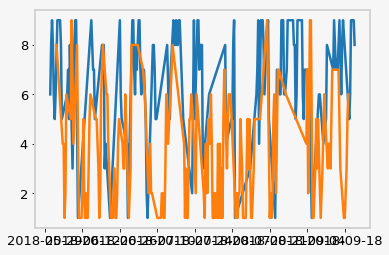

In [36]:
L1 = five_Period_df[five_Period_df['EOSUSDT:binance']>0].index.tolist()
L2 = five_Period_df[five_Period_df['EOSUSDT:binance']<0].index.tolist()
alpha4P1 = alpha4['EOSUSDT:binance'][L1]
alpha4P2 = alpha4['EOSUSDT:binance'][L2]
# five_Period_df['BTCUSDT:binance']<0
# five_Period_df[five_Period_df<0] = -1
plt.plot(alpha4P1.iloc[-250:])
plt.plot(alpha4P2.iloc[-250:])

In [37]:
# 进场信号
long = dv8H.add_formula("longAlpha4","If(alpha4_C>6 ,2,0)", add_data=True)
short = dv8H.add_formula("shortAlpha4","If(alpha4_C<2,-2,0)", add_data=True)

# 出场信号5
close_long = dv8H.add_formula("closeLongAlpha4","If(shortAlpha4==-2,1,0)", add_data=True)
close_short = dv8H.add_formula("closeShortAlpha4","If(longAlpha4==2,-1,0)", add_data=True)
dv8H.get_ts('longAlpha4').stack()[dv8H.get_ts('longAlpha4').stack()==2].tail()

trade_date      symbol         
20180920080000  EOSUSDT:binance    2.0
20180920160000  EOSUSDT:binance    2.0
20180921000000  EOSUSDT:binance    2.0
20180921080000  EOSUSDT:binance    2.0
20180921160000  EOSUSDT:binance    2.0
dtype: float64

In [38]:
tdAlpha4 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha004')

TimingSignal(tdAlpha4, dv8H,'longAlpha4','shortAlpha4','closeLongAlpha4','closeShortAlpha4', 5, 0.05, 0.3)#

Nan Data Count (should be zero) : 0;  Percentage of effective data: 33%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 16%


In [39]:
tdAlpha4.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.168 -12.088   -0.061
p-value              0.000   0.000    0.952
mean                 0.061  -0.057   -0.000
std                  0.055   0.036    0.075
info_ratio           1.112  -1.574   -0.006
skewness             0.822  -0.133    0.553
kurtosis            -0.364  -1.181   -0.194
pct5                 0.004  -0.113   -0.111
pct25                0.015  -0.081   -0.059
pct50                0.036  -0.058   -0.004
pct75                0.100  -0.022    0.033
pct95                0.165  -0.005    0.137
occurance           55.000  60.000  115.000
win_ratio              NaN     NaN    0.478
win_mean/loss_mean     NaN     NaN    1.075


In [40]:
tdAlpha4.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.429  -7.057   0.238
p-value              0.000   0.000   0.813
mean                 0.053  -0.055   0.002
std                  0.052   0.039   0.071
info_ratio           1.026  -1.411   0.032
skewness             1.388  -0.543   0.470
kurtosis             0.860  -0.259   0.416
pct5                 0.004  -0.120  -0.100
pct25                0.018  -0.076  -0.054
pct50                0.034  -0.056   0.003
pct75                0.059  -0.024   0.035
pct95                0.174  -0.002   0.144
occurance           29.000  26.000  55.000
win_ratio              NaN     NaN   0.527
win_mean/loss_mean     NaN     NaN   0.976


In [41]:
tdAlpha4.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               9.839 -14.024    0.080
p-value              0.000   0.000    0.937
mean                 0.059  -0.056    0.000
std                  0.054   0.037    0.074
info_ratio           1.080  -1.521    0.006
skewness             1.000  -0.268    0.527
kurtosis            -0.046  -0.871   -0.023
pct5                 0.003  -0.113   -0.111
pct25                0.016  -0.081   -0.057
pct50                0.035  -0.057   -0.001
pct75                0.097  -0.023    0.035
pct95                0.176  -0.004    0.139
occurance           84.000  86.000  170.000
win_ratio              NaN     NaN    0.494
win_mean/loss_mean     NaN     NaN    1.040


In [42]:
# 进场信号
long = dv8H.add_formula("longAlpha7","If(alpha7_C>0 ,2,0)", add_data=True)
short = dv8H.add_formula("shortAlpha7","If(alpha7_C<0,-2,0)", add_data=True)

# 出场信号5
close_long = dv8H.add_formula("closeLongAlpha7","If(shortAlpha7==-2,1,0)", add_data=True)
close_short = dv8H.add_formula("closeShortAlpha7","If(longAlpha7==2,-1,0)", add_data=True)
dv8H.get_ts('longAlpha7').stack()[dv8H.get_ts('longAlpha7').stack()==2].tail()

trade_date      symbol         
20180920080000  EOSUSDT:binance    2.0
20180920160000  EOSUSDT:binance    2.0
20180921000000  EOSUSDT:binance    2.0
20180921080000  EOSUSDT:binance    2.0
20180921160000  EOSUSDT:binance    2.0
dtype: float64

In [43]:
tdAlpha7 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha007')

TimingSignal(tdAlpha7, dv8H,'longAlpha7','shortAlpha7','closeLongAlpha7','closeShortAlpha7',5, 0.05, 0.5)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 64%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 23%


In [44]:
tdAlpha7.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               11.346  -13.992    0.040
p-value               0.000    0.000    0.968
mean                  0.050   -0.046    0.000
std                   0.046    0.035    0.063
info_ratio            1.102   -1.299    0.003
skewness              0.931   -0.622    0.400
kurtosis              0.005   -0.543    0.076
pct5                  0.002   -0.111   -0.097
pct25                 0.011   -0.071   -0.040
pct50                 0.033   -0.037   -0.004
pct75                 0.084   -0.015    0.032
pct95                 0.140   -0.004    0.115
occurance           107.000  117.000  224.000
win_ratio               NaN      NaN    0.478
win_mean/loss_mean      NaN      NaN    1.101


In [47]:
tdAlpha7.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.981  -6.473   0.896
p-value              0.000   0.000   0.373
mean                 0.044  -0.029   0.006
std                  0.053   0.028   0.056
info_ratio           0.819  -1.011   0.101
skewness             1.659  -2.043   1.220
kurtosis             1.803   5.771   3.251
pct5                 0.003  -0.070  -0.058
pct25                0.009  -0.045  -0.021
pct50                0.021  -0.020  -0.001
pct75                0.048  -0.009   0.017
pct95                0.149  -0.002   0.119
occurance           38.000  42.000  80.000
win_ratio              NaN     NaN   0.475
win_mean/loss_mean     NaN     NaN   1.515


In [48]:
tdAlpha7.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               12.174  -15.089    0.456
p-value               0.000    0.000    0.649
mean                  0.049   -0.041    0.002
std                   0.048    0.034    0.061
info_ratio            1.015   -1.200    0.026
skewness              1.170   -0.892    0.552
kurtosis              0.640    0.120    0.716
pct5                  0.002   -0.110   -0.093
pct25                 0.011   -0.067   -0.033
pct50                 0.029   -0.031   -0.003
pct75                 0.078   -0.011    0.027
pct95                 0.142   -0.004    0.118
occurance           145.000  159.000  304.000
win_ratio               NaN      NaN    0.477
win_mean/loss_mean      NaN      NaN    1.178
